In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import keras.backend as K
import os
import re
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

2024-07-01 10:42:54.828506: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
print(tf.__version__)
print(keras.__version__)
print(np.__version__)
print(pd.__version__)

2.4.1
2.4.0
1.19.5
1.1.5


In [3]:
# GPU 사용을 강제로 차단하고 CPU만 사용
tf.config.set_visible_devices([], 'GPU')
# # TensorFlow 작업에 사용할 스레드 수를 28개로 설정
# tf.config.threading.set_intra_op_parallelism_threads(20)

2024-07-01 10:43:00.135365: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-01 10:43:00.139575: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-07-01 10:43:00.169277: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-07-01 10:43:00.169313: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nccpml156
2024-07-01 10:43:00.169320: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nccpml156
2024-07-01 10:43:00.169461: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.183.1
2024-07-01 10:43:00.169487: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.171.4
2024-07-01 10:4

In [4]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# 사용자 정의 지표 등록
get_custom_objects().update({'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})

# AUC 및 PRAUC 계산 함수 정의
def calculate_metrics(model, data, labels):
    y_pred_prob = model.predict(data)
    y_true = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
    
    aucs = []
    praucs = []
    
    for i in range(num_classes):
        true_labels = y_true[:, i]
        pred_prob = y_pred_prob[:, i]
        
        auc_value = roc_auc_score(true_labels, pred_prob)
        precision, recall, _ = precision_recall_curve(true_labels, pred_prob)
        prauc_value = auc(recall, precision)
        
        aucs.append(auc_value)
        praucs.append(prauc_value)
    
    return aucs, praucs

In [5]:
# 파일 이름에서 숫자 부분을 추출하여 정수로 변환하여 정렬
path = '/home/nccpml/DATA2/hanbyeol/TEC/cnn_input_data09/'

def extract_number(filename):
    return int(re.search(r'\d+', filename).group())

class_files = sorted([f for f in os.listdir(path) if f.endswith(".npz")], key=extract_number)
class_files

['combi-cells_c0.npz',
 'combi-cells_c1.npz',
 'combi-cells_c2.npz',
 'combi-cells_c3.npz',
 'combi-cells_c4.npz',
 'combi-cells_c5.npz',
 'combi-cells_c6.npz',
 'combi-cells_c7.npz',
 'combi-cells_c8.npz',
 'combi-cells_c9.npz',
 'combi-cells_c10.npz']

In [6]:
# 데이터 및 라벨을 위한 리스트 초기화
data = []
labels = []

# 각 클래스 파일에 대한 데이터 로드 및 라벨 할당
for i, class_file in enumerate(class_files):
    # .npz 파일 로드
    loaded = np.load(path + class_file)
    # 로드된 데이터를 배열로 변환 (리스트로 변환 필요)
    class_data = np.stack([loaded[key] for key in loaded.files])
    # 클래스에 대한 라벨 할당
    class_labels = np.ones(class_data.shape[0]) * i
    
    # 데이터 및 라벨 추가
    data.append(class_data)
    labels.append(class_labels)

    
    print("Loading done: ", i)

# 데이터 및 라벨 배열을 하나로 결합
data = np.concatenate(data, axis=0)
labels = np.concatenate(labels, axis=0)
data[np.isnan(data)] = 0

# 최종 데이터 및 라벨 형태 확인
print(f"Total data shape: {data.shape}")
print(f"Total labels shape: {labels.shape}")

Loading done:  0
Loading done:  1
Loading done:  2
Loading done:  3
Loading done:  4
Loading done:  5
Loading done:  6
Loading done:  7
Loading done:  8
Loading done:  9
Loading done:  10
Total data shape: (5500, 100, 12962, 2)
Total labels shape: (5500,)


In [7]:
# Split the data into training and validation sets
# 64%train * 16%val * 20%test
X_tmp, test_data, Y_tmp, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(X_tmp, Y_tmp, test_size=0.2, random_state=44)

In [8]:
num_lrpair = data.shape[2]
num_classes = len(class_files)
print(num_lrpair, num_classes)

12962 11


In [9]:
# CNN 모델 생성
model = tf.keras.Sequential([
    # First Conv2D layer for reducing channels
    layers.Conv2D(8, (1, 1), activation='relu', kernel_initializer='he_normal', 
                  input_shape=(100, num_lrpair, 2)),
    # Second Conv2D layer
    layers.Conv2D(16, (10, 1), strides=(10, 1), activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    # Additional Conv2D layers or other layers
    layers.Conv2D(16, (10, 1), strides=(10, 1), activation='relu', kernel_initializer='he_normal'),
    layers.MaxPooling2D((1, 4)),
    layers.Conv2D(32, (1, 4), activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((1, 2)),
    # Global Average Pooling layer
    layers.GlobalAveragePooling2D(),
    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', f1_m, precision_m, recall_m])


2024-07-01 10:54:18.588807: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 10:54:18.589988: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [10]:
# 모델 학습
history = model.fit(train_data, train_labels, 
                    validation_data=(val_data, val_labels), 
                    epochs=12, batch_size=32)

# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.legend(['training', 'validation'], loc = 'upper left')
# plt.show()

2024-06-20 08:48:22.732971: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36500992000 exceeds 10% of free system memory.
2024-06-20 08:48:38.962923: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-06-20 08:48:38.985762: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


Epoch 1/12


2024-06-20 08:48:40.436271: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1327308800 exceeds 10% of free system memory.
2024-06-20 08:48:41.275931: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1327308800 exceeds 10% of free system memory.


  1/110 [..............................] - ETA: 6:21 - loss: 2.3861 - accuracy: 0.1562 - f1_m: 10.4667 - precision_m: 1570000000.0000 - recall_m: 5.2333

2024-06-20 08:48:42.511665: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1327308800 exceeds 10% of free system memory.
2024-06-20 08:48:42.981334: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1327308800 exceeds 10% of free system memory.


110/110 [==============================] - 221s 2s/step - loss: 2.3687 - accuracy: 0.1149 - f1_m: 9.7644 - precision_m: 1348200267.5315 - recall_m: 4.8957 - val_loss: 2.6236 - val_accuracy: 0.0739 - val_f1_m: 4.8168 - val_precision_m: 11.8120 - val_recall_m: 3.0723
Epoch 2/12
110/110 [==============================] - 211s 2s/step - loss: 1.8461 - accuracy: 0.3211 - f1_m: 5.0567 - precision_m: 12696342.3979 - recall_m: 2.8660 - val_loss: 3.6701 - val_accuracy: 0.0750 - val_f1_m: 2.5131 - val_precision_m: 2.8708 - val_recall_m: 2.2466
Epoch 3/12
110/110 [==============================] - 214s 2s/step - loss: 1.0842 - accuracy: 0.6072 - f1_m: 2.6414 - precision_m: 4.0742 - recall_m: 1.9844 - val_loss: 3.7529 - val_accuracy: 0.2273 - val_f1_m: 1.4424 - val_precision_m: 1.4219 - val_recall_m: 1.4647
Epoch 4/12
110/110 [==============================] - 218s 2s/step - loss: 0.6755 - accuracy: 0.7577 - f1_m: 1.9375 - precision_m: 2.3182 - recall_m: 1.6798 - val_loss: 0.6875 - val_accuracy: 0

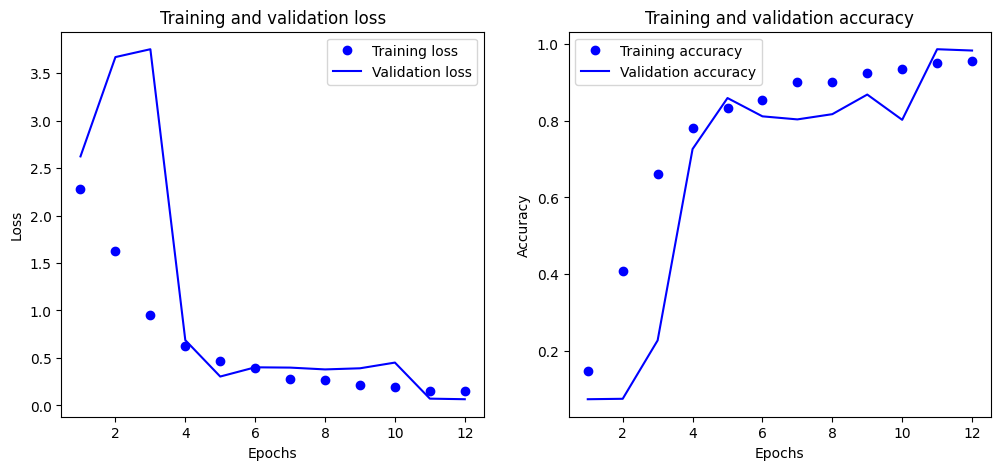

In [11]:
import matplotlib.pyplot as plt

# 학습 과정의 손실과 정확도 기록을 history 객체에서 추출
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# 손실 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [12]:
#### Evaluate the model ####
loss, accuracy, f1_score, precision, recall = model.evaluate(test_data, test_labels, verbose=1)

35/35 [==============================] - 11s 250ms/step - loss: 0.0593 - accuracy: 0.9864 - f1_m: 0.9709 - precision_m: 0.9311 - recall_m: 1.0156


In [13]:
# # Save the trained model
save_path = "/home/nccpml/DATA2/hanbyeol/TEC/cnn_model091/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

model.save(save_path + 'data_cnn-model_v8.h5')

In [10]:
# 모델 불러오기
save_path = "/home/nccpml/DATA2/hanbyeol/TEC/cnn_model091/"
model = tf.keras.models.load_model(save_path + "data_cnn-model_v01.h5",
                                   custom_objects={'f1_m': f1_m, 
                                                   'precision_m': precision_m, 
                                                   'recall_m': recall_m})

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 12962, 8)     24        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 12962, 16)     1296      
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 12962, 16)     64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 12962, 16)      2576      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 3240, 16)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 3237, 32)       2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 3237, 32)       1

In [12]:
## AUC와 PRAUC를 계산  시각화

AUC Metrics
      Model   Class_0   Class_1   Class_2   Class_3   Class_4   Class_5  \
0   Model_1  1.000000  1.000000  0.983884  1.000000  1.000000  1.000000   
1   Model_2  0.966467  1.000000  0.999917  0.999313  1.000000  1.000000   
2   Model_3  0.997839  0.999772  0.985739  0.999755  0.999469  0.999508   
3   Model_4  0.988724  1.000000  0.999702  1.000000  1.000000  0.998727   
4   Model_5  0.998165  1.000000  1.000000  1.000000  1.000000  1.000000   
5   Model_6  0.999852  1.000000  0.999934  1.000000  1.000000  1.000000   
6   Model_7  0.999837  1.000000  1.000000  1.000000  1.000000  1.000000   
7   Model_8  0.986977  1.000000  0.997333  1.000000  1.000000  1.000000   
8   Model_9  1.000000  1.000000  0.999983  1.000000  1.000000  1.000000   
9  Model_10  0.980437  1.000000  0.999834  0.999967  0.999781  0.999389   

   Class_6  Class_7   Class_8  Class_9  Class_10  
0      1.0      1.0  1.000000      1.0       1.0  
1      1.0      1.0  1.000000      1.0       1.0  
2      1.

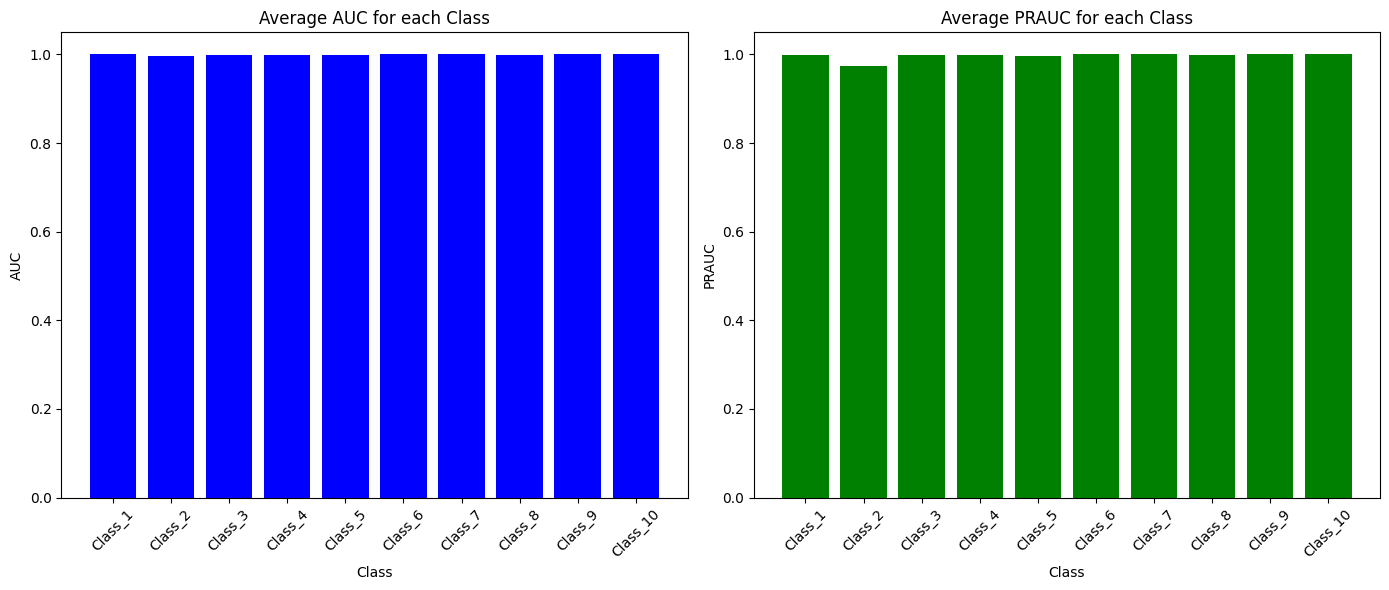

In [14]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# AUC 및 PRAUC 계산 함수 정의
def calculate_metrics(model, data, labels, num_classes):
    y_pred_prob = model.predict(data)
    y_true = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
    
    aucs = []
    praucs = []
    
    for i in range(num_classes):
        true_labels = y_true[:, i]
        pred_prob = y_pred_prob[:, i]
        
        auc_value = roc_auc_score(true_labels, pred_prob)
        precision, recall, _ = precision_recall_curve(true_labels, pred_prob)
        prauc_value = auc(recall, precision)
        
        aucs.append(auc_value)
        praucs.append(prauc_value)
    
    return aucs, praucs

# 모델 로드 및 메트릭 계산
save_path = "/home/nccpml/DATA2/hanbyeol/TEC/cnn_model091/"
model_files = [f for f in os.listdir(save_path) if f.startswith("data_cnn-model_v") and f.endswith(".h5")]

# 데이터 및 라벨 준비
num_classes = 11  # 클래스 수 설정

auc_results = []
prauc_results = []

for model_file in model_files:
    model = tf.keras.models.load_model(save_path + model_file,
                                       custom_objects={'f1_m': f1_m, 
                                                       'precision_m': precision_m, 
                                                       'recall_m': recall_m})
    aucs, praucs = calculate_metrics(model, val_data, val_labels, num_classes)
    auc_results.append(aucs)
    prauc_results.append(praucs)

# 결과를 데이터프레임으로 정리
auc_df = pd.DataFrame(auc_results, columns=[f'Class_{i}' for i in range(num_classes)])
auc_df.insert(0, 'Model', [f'Model_{i+1}' for i in range(len(model_files))])

prauc_df = pd.DataFrame(prauc_results, columns=[f'Class_{i}' for i in range(num_classes)])
prauc_df.insert(0, 'Model', [f'Model_{i+1}' for i in range(len(model_files))])

In [19]:
class_names = ['Tip_Cells', 'activated capillary', 'Immature_Phenotype',
               'capillary_I', 'capillary_II', 'Activated_EC', 'TandNK', 
               'Epithelial', 'Myeloid', 'Fibro_Peri', 'B']

# 데이터프레임의 열 이름 변경
auc_df.columns = ['Model'] + class_names
prauc_df.columns = ['Model'] + class_names

In [29]:
auc_df.round(4)

,Model,Tip_Cells,activated capillary,Immature_Phenotype,capillary_I,capillary_II,Activated_EC,TandNK,Epithelial,Myeloid,Fibro_Peri,B
0,Model_1,1.0000,1.0000,0.9839,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
1,Model_2,0.9665,1.0000,0.9999,0.9993,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
2,Model_3,0.9978,0.9998,0.9857,0.9998,0.9995,0.9995,1.0,1.0,0.9996,1.0,1.0
3,Model_4,0.9887,1.0000,0.9997,1.0000,1.0000,0.9987,1.0,1.0,1.0000,1.0,1.0
4,Model_5,0.9982,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
5,Model_6,0.9999,1.0000,0.9999,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
6,Model_7,0.9998,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
7,Model_8,0.9870,1.0000,0.9973,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
8,Model_9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
9,Model_10,0.9804,1.0000,0.9998,1.0000,0.9998,0.9994,1.0,1.0,1.0000,1.0,1.0


In [28]:
prauc_df.round(4)

,Model,Tip_Cells,activated capillary,Immature_Phenotype,capillary_I,capillary_II,Activated_EC,TandNK,Epithelial,Myeloid,Fibro_Peri,B
0,Model_1,1.0000,1.0000,0.8844,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
1,Model_2,0.7255,1.0000,0.9991,0.9920,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
2,Model_3,0.9835,0.9981,0.8862,0.9976,0.9950,0.9952,1.0,1.0,0.9961,1.0,1.0
3,Model_4,0.9069,1.0000,0.9969,1.0000,1.0000,0.9865,1.0,1.0,1.0000,1.0,1.0
4,Model_5,0.9874,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
5,Model_6,0.9986,1.0000,0.9993,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
6,Model_7,0.9985,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
7,Model_8,0.8944,1.0000,0.9766,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
8,Model_9,1.0000,1.0000,0.9998,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0,1.0
9,Model_10,0.8773,1.0000,0.9983,0.9997,0.9981,0.9938,1.0,1.0,1.0000,1.0,1.0


In [34]:
prauc_df

,Model,Tip_Cells,activated capillary,Immature_Phenotype,capillary_I,capillary_II,Activated_EC,TandNK,Epithelial,Myeloid,Fibro_Peri,B
0,Model_1,1.000000,1.000000,0.884350,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
1,Model_2,0.725510,1.000000,0.999142,0.991988,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
2,Model_3,0.983497,0.998092,0.886248,0.997633,0.994998,0.995218,1.0,1.0,0.996054,1.0,1.0
3,Model_4,0.906918,1.000000,0.996917,1.000000,1.000000,0.986453,1.0,1.0,1.000000,1.0,1.0
4,Model_5,0.987387,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
5,Model_6,0.998565,1.000000,0.999321,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
6,Model_7,0.998476,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
7,Model_8,0.894422,1.000000,0.976583,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
8,Model_9,1.000000,1.000000,0.999823,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
9,Model_10,0.877345,1.000000,0.998318,0.999660,0.998128,0.993822,1.0,1.0,1.000000,1.0,1.0


In [37]:
auc_df.mean(axis=0)[0:]

Tip_Cells              0.991830
activated capillary    0.999977
Immature_Phenotype     0.996633
capillary_I            0.999903
capillary_II           0.999925
Activated_EC           0.999762
TandNK                 1.000000
Epithelial             1.000000
Myeloid                0.999963
Fibro_Peri             1.000000
B                      1.000000
dtype: float64

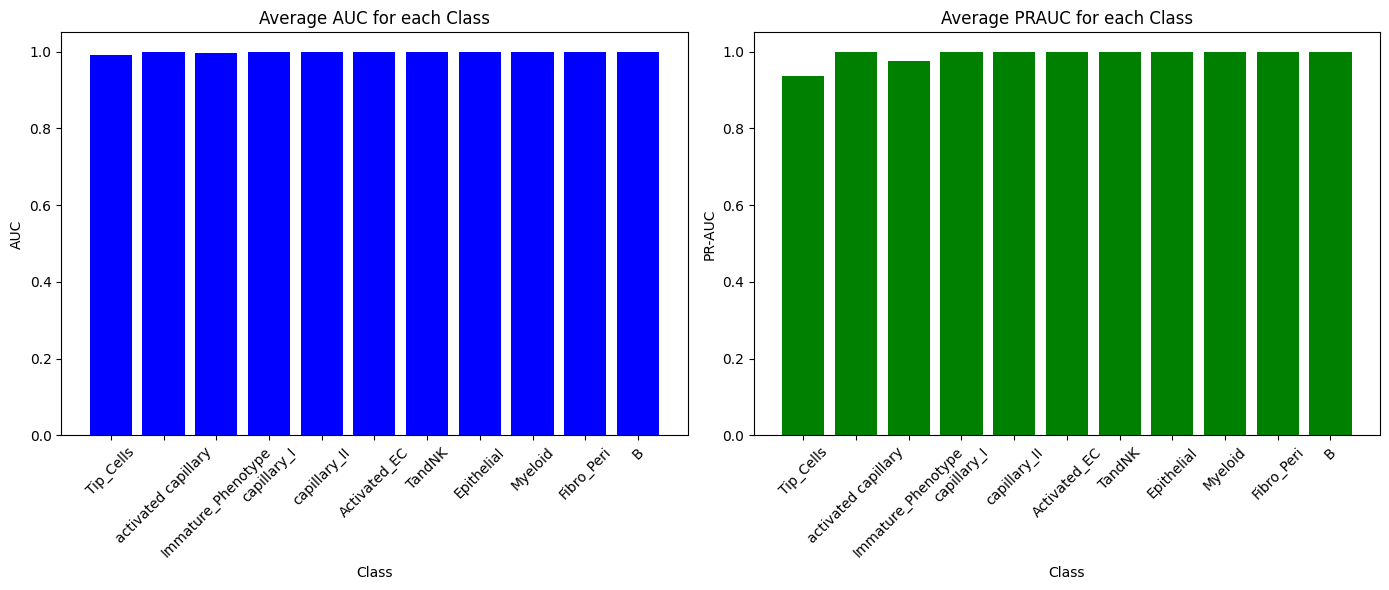

In [39]:
# 각 클래스의 평균 계산
auc_mean = auc_df.mean(axis=0)[0:]  # 'Model' 열 제외
prauc_mean = prauc_df.mean(axis=0)[0:]  # 'Model' 열 제외

# 시각화
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# AUC 평균 시각화
axs[0].bar(auc_mean.index, auc_mean.values, color='blue')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('AUC')
axs[0].set_title('Average AUC for each Class')
axs[0].tick_params(axis='x', rotation=45)

# PRAUC 평균 시각화
axs[1].bar(prauc_mean.index, prauc_mean.values, color='green')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('PR-AUC')
axs[1].set_title('Average PRAUC for each Class')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## GradCAM++

In [5]:
# import numpy as np
# from matplotlib import pyplot as plt
# from matplotlib import cm
# from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
# from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
# from tf_keras_vis.utils.scores import CategoricalScore
import pandas as pd
import os

## GradCAM++ 모델 전부 돌리기

In [6]:
# load data
model_paths = "/home/nccpml/DATA2/hanbyeol/TEC/cnn_model091/"
model_names = sorted([f for f in os.listdir(model_paths) if f.endswith('.h5')])

# class_names = ['TEC', 'NEC', 'Myeloid', 'Epithelial', 'Fibro_Peri', 'TandNK', 'B']
class_names = ['Tip_Cells', 'activated capillary', 'Immature_Phenotype',
               'capillary_I', 'capillary_II', 'Activated_EC', 'TandNK', 
               'Epithelial', 'Myeloid', 'Fibro_Peri', 'B']

# L-R interaction 유전자 데이터 로드
file_path = '/home/nccpml/DATA2/hanbyeol/TEC/'
gene_list_df = pd.read_csv(file_path + 'CCIdb/CCIdb09.csv')
genes = gene_list_df['TumorGene'].tolist()
genes1 = gene_list_df['OtherGene'].tolist()
print(model_names)

['data_cnn-model_v01.h5', 'data_cnn-model_v02.h5', 'data_cnn-model_v03.h5', 'data_cnn-model_v04.h5', 'data_cnn-model_v05.h5', 'data_cnn-model_v06.h5', 'data_cnn-model_v07.h5', 'data_cnn-model_v08.h5', 'data_cnn-model_v09.h5', 'data_cnn-model_v10.h5']


In [11]:
save_path = '/home/nccpml/DATA2/hanbyeol/TEC/gcam_res092/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

for model_name in model_names:
    version_suffix = model_name.split('_')[-1].replace('.h5', '')
    model = tf.keras.models.load_model(model_paths + model_name,
                                  custom_objects={'f1_m':f1_m, 
                                                  'precision_m':precision_m, 
                                                  'recall_m':recall_m})

    # GradCAM++ 객체 생성
    gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=True)

    for class_index, class_name in enumerate(class_names):
        # 해당 클래스의 데이터 선택
        start_index = class_index * 500  # 각 클래스는 1000개의 데이터 포인트를 가짐
        end_index = start_index + 500
        class_data = data[start_index:end_index]
        class_labels = np.full((500,), class_index)  # 모든 데이터 포인트에 대해 동일한 라벨을 가짐
        
        # Heatmap 생성
        cam_tot = np.mean([
            gradcam(CategoricalScore(label), np.expand_dims(sample, axis=0), penultimate_layer=-1)
            for label, sample in zip(class_labels, class_data)
        ], axis=0)
        
        # cam_tot 정규화
        cam_sum = np.mean(cam_tot[0], axis=0)
        cam_max, cam_min = cam_sum.max(), cam_sum.min()
        cam_mod = (cam_sum - cam_min) / (cam_max - cam_min)
        
        # 결과 파일 저장
        line_1st = f'TumorCell\t{class_name}\tNormalized_Weight'
        line_ext = [f'{genes[i]}\t{genes1[i]}\t{str(cam_mod[i])}' for i in range(len(genes))]
        
        # 파일에 쓰기
        file_name = f"gcamplus_result_{class_name}_{version_suffix}.txt"
        full_path = os.path.join(save_path, file_name)
        with open(full_path, "w") as f_out:
            f_out.write(line_1st + '\n')
            f_out.write('\n'.join(line_ext))
        
        print(f"Completed: {file_name}")

Completed: gcamplus_result_Tip_Cells_v08.txt
Completed: gcamplus_result_activated capillary_v08.txt
Completed: gcamplus_result_Immature_Phenotype_v08.txt
Completed: gcamplus_result_capillary_I_v08.txt
Completed: gcamplus_result_capillary_II_v08.txt
Completed: gcamplus_result_Activated_EC_v08.txt
Completed: gcamplus_result_TandNK_v08.txt
Completed: gcamplus_result_Epithelial_v08.txt
Completed: gcamplus_result_Myeloid_v08.txt
Completed: gcamplus_result_Fibro_Peri_v08.txt
Completed: gcamplus_result_B_v08.txt


## Evaluate the model

In [40]:
# Evaluate the model
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
import numpy as np
import tensorflow as tf

# 예측 라벨을 계산합니다.
val_predictions = model.predict(val_data)
val_pred_labels = np.argmax(val_predictions, axis=1)

In [41]:
val_predictions.dtype, val_pred_labels.dtype

(dtype('float32'), dtype('int64'))

In [42]:
# 실제 라벨과 예측 라벨 classification_report
print(classification_report(val_labels, val_pred_labels))

# 모델 평가
results = model.evaluate(val_data, val_labels)
# 결과 리스트에서 첫 번째 값은 손실, 두 번째 값은 정확도
loss = results[0]
accuracy = results[1]

print("Overall Accuracy:", accuracy)
print("Loss:", loss)

# 실제 라벨과 예측 라벨을 사용 계산
f1_score_weighted = f1_score(val_labels, val_pred_labels, average='weighted')
recall_weighted = recall_score(val_labels, val_pred_labels, average='weighted')
precision_weighted = precision_score(val_labels, val_pred_labels, average='weighted')

print(f"F1 Score (Weighted): {f1_score_weighted}")
print(f"Recall (Weighted): {recall_weighted}")
print(f"Precision (Weighted): {precision_weighted}")

              precision    recall  f1-score   support

         0.0       0.95      0.66      0.78        85
         1.0       1.00      0.92      0.96        95
         2.0       1.00      0.93      0.97        75
         3.0       0.92      1.00      0.96        76
         4.0       0.75      1.00      0.86        80
         5.0       0.96      0.93      0.94        73
         6.0       0.94      1.00      0.97        84
         7.0       0.96      1.00      0.98        71
         8.0       1.00      1.00      1.00        73
         9.0       1.00      1.00      1.00        90
        10.0       1.00      1.00      1.00        78

    accuracy                           0.95       880
   macro avg       0.95      0.95      0.95       880
weighted avg       0.95      0.95      0.95       880



TypeError: in user code:

    /home/hanbyeol/anaconda3/envs/py39/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /home/hanbyeol/anaconda3/envs/py39/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/hanbyeol/anaconda3/envs/py39/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/hanbyeol/anaconda3/envs/py39/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/hanbyeol/anaconda3/envs/py39/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/hanbyeol/anaconda3/envs/py39/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1219 run_step  **
        with ops.control_dependencies(_minimum_control_deps(outputs)):
    /home/hanbyeol/anaconda3/envs/py39/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2793 _minimum_control_deps
        outputs = nest.flatten(outputs, expand_composites=True)
    /home/hanbyeol/anaconda3/envs/py39/lib/python3.8/site-packages/tensorflow/python/util/nest.py:341 flatten
        return _pywrap_utils.Flatten(structure, expand_composites)

    TypeError: '<' not supported between instances of 'function' and 'str'


In [43]:
#### CNN confusion matrix ####

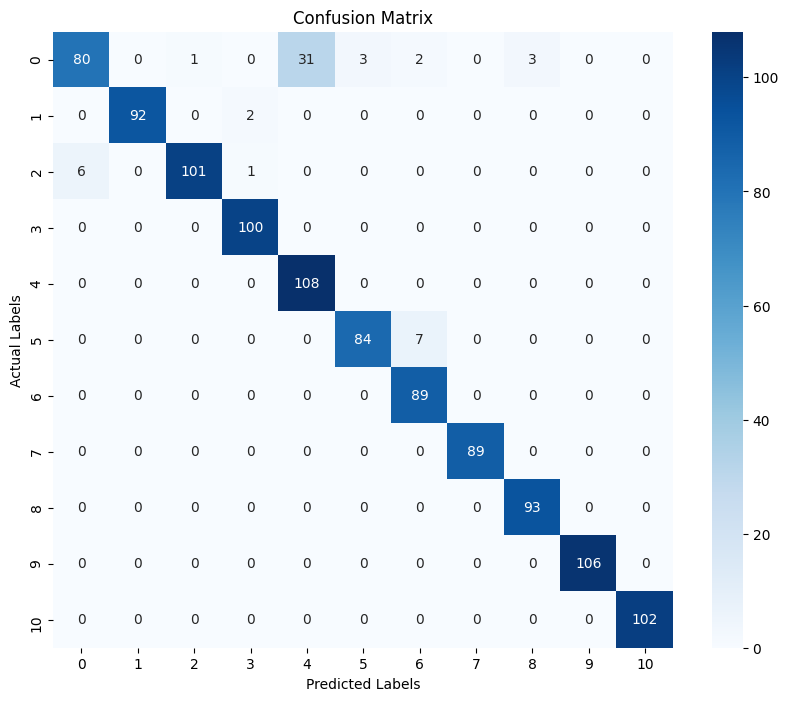

In [44]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 모델로부터 예측값 얻기
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# 실제 라벨과 예측 라벨을 사용하여 혼동 행렬 생성
cm = confusion_matrix(test_labels, predicted_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


## AUC

In [19]:
from seqeval.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# 테스트 데이터에 대한 예측 확률
y_pred = model.predict(test_data)

# 실제 라벨을 One-hot 형식으로 변환
class_num = len(class_files)
y_test = label_binarize(test_labels, classes=np.arange(class_num))
n_classes = y_test.shape[1]
n_classes

In [ ]:
# 테스트 데이터에 대한 예측 확률
y_pred = model.predict(test_data)

# 실제 라벨을 One-hot 형식으로 변환
y_test = label_binarize(test_labels, classes=np.arange(class_num))

# 클래스의 수
n_classes = y_test.shape[1]

# 각 클래스에 대한 ROC 커브와 AUC를 계산합니다
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 각 클래스에 대해 ROC 커브를 그립니다
# colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black'])
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown', 'gray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()


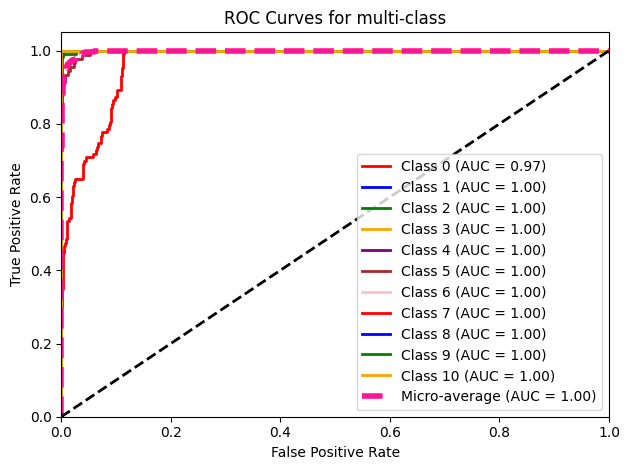

In [37]:
# Number of classes
n_classes = y_test.shape[1]

# Predictions
val_predictions = model.predict(test_data)

# Convert class labels to one-hot encoded format
one_hot_val_labels = tf.keras.utils.to_categorical(test_labels, num_classes=n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(one_hot_val_labels[:, i], val_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(one_hot_val_labels.ravel(), val_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure() #figsize=(8, 6)
colors = cycle(['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], linestyle='--',
         label='Micro-average (AUC = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for multi-class')
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig('res04__cnn-performance.png', dpi=200)
plt.show()

